# Research Hackathon project on wildfires in U.S.A.
## Setup (for now):
- **Research Question**: ...
Motivated by an introduction, and possibly a literature review.
- **Data description**
- **Preliminary analysis**: e.g. where do wildfires frequently occur and how are the sizes of fire distributed over the US? what seasonality patterns are in the wildfire frequencies? are there already relationships of interest (depends on the research question) visible without any ML/econometric model? etc.
- **Analysis**: targetted at research question, so t.b.d.
- **Conclusion**: link intro + research question to findings of (preliminary) analysis 

## Possible research questions:
- Can we build a pipeline to forecast the frequency, size and location of wildfires? We can motivate this using central fire brigade allocation for instance.
- How are extreme wildfires distributed? Motivated by the fact that they occur more often now, and we want to help institutions prevent large damages, we want to give inference on the extreme wildfires.
- OR approach: can we build an ML pipeline to model the arrivals (discoveries) and departures (containments) of wildfires?

In [1]:
# Imports
import pandas as pd
import numpy as np
from plotly.offline import iplot
import plotly.graph_objects as go
import plotly.io as pio
import statsmodels.formula.api as sm
import sklearn as skl

In [2]:
#pip install plotly

# **Load wildfire data**
SQL data has been loaded in Spyder. The data of interest has been exported to a CSV-file. See snippet below. This CSV-file is imported here.

In [3]:
df = pd.read_csv('wildfire_data_climate_nearby.csv')
print('Number of fires:', df.shape[0])
df.head()

Number of fires: 892007


/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: DtypeWarning:

Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.



,Unnamed: 0,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,FIPS_CODE,FIPS_NAME,DISCOVERY_DATE,DISCOVERY_DOY,...,pdsi,DATE,MONTH,tmp_monthly,pcp_monthly,pdsi_monthly,DAY_TO_CONT,HOUR_TO_CONT,NEARBY_HOUR_TO_CONT,NEARBY_DAY_TO_CONT
0,0,2005,Miscellaneous,40.036944,-121.005833,CA,63.0,Plumas,2453403.5,33,...,3.050000,2005-02-02,2,47.1,4.03,2.28,0,4,110.900000,5.0
1,1,2004,Lightning,38.933056,-120.404444,CA,61.0,Placer,2453137.5,133,...,-1.234545,2004-05-12,5,63.2,0.45,-2.15,0,7,29.902778,1.0
2,2,2004,Debris Burning,38.984167,-120.735556,CA,17.0,El Dorado,2453156.5,152,...,-1.234545,2004-05-31,5,63.2,0.45,-2.15,0,1,23.119355,1.0
3,3,2004,Lightning,38.559167,-119.913333,CA,3.0,Alpine,2453184.5,180,...,-1.234545,2004-06-28,6,70.4,0.08,-2.80,5,118,16.709821,1.0
4,4,2004,Lightning,38.559167,-119.933056,CA,3.0,Alpine,2453184.5,180,...,-1.234545,2004-06-28,6,70.4,0.08,-2.80,5,116,16.570796,1.0


The feature matching is performed in my local server because of unstable connection here. See 'ClimateMatch.py' for the code.

**Six new features are added:**
- 'tmp_monthly': the average temprature of the month in the state when and where the fire happened.
- 'pcp_monthly': the average precipitation of the month in the state when and where the fire happened.
- 'pdsi_monthly': the Palmer Drought Severity Index of the month in the state when and where the fire happened.
- 'tmp_yearly': the average temprature of the year in the state when and where the fire happened.
- 'pcp_monthly': the average precipitition of the year in the state when and where the fire happened.
- 'pdsi_monthly': the average Palmer Drought Severity Index of the year in the state when and where the fire happened.

*Note that the missing values are marked as -99.99.*

**Data source:** 

Vose, R. S., Applequist, S., Squires, M., Durre, I., Menne, M. J., Williams, C. N., Jr., Fenimore, C., Gleason, K., & Arndt, D. (2014). Improved Historical Temperature and Precipitation Time Series for U.S. Climate Divisions, Journal of Applied Meteorology and Climatology, 53(5), 1232-1251. Retrieved Feb 6, 2023, from https://journals.ametsoc.org/view/journals/apme/53/5/jamc-d-13-0248.1.xml

Readme file of the dataset: https://www.ncei.noaa.gov/pub/data/cirs/climdiv/state-readme.txt


Data file used in the the following analysis: 'climdiv-pcpnst-v1.0.0-20230106.txt', 'climdiv-pdsist-v1.0.0-20230106.txt', and 'climdiv-tmpcst-v1.0.0-20230106.txt'

In [4]:
df['FIRE_SIZE_CLASS_NUM'] = [ord(x) - 64 for x in df.FIRE_SIZE_CLASS]
#df = df[df.HOUR_TO_CONT>0]

## ML Classification

In [5]:
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

## for explainer
#from lime import lime_tabular

In [6]:
# Remove missing values
df=df[(df['tmp_monthly']!=-99.99) & (df['pcp_monthly']!=-99.99) & (df['pdsi_monthly']!=-99.99)]
df=df[["LATITUDE",'LONGITUDE','FIRE_SIZE_CLASS_NUM', 'DISCOVERY_DOY', 'FIRE_YEAR','tmp_monthly','pdsi_monthly',
         'pcp_monthly','NEARBY_HOUR_TO_CONT','HOUR_TO_CONT','STAT_CAUSE_DESCR','STATE']]
df.dropna(axis=0,inplace=True)

In [7]:
# Create dummy variable to predict
dThreshold = 5
df['Y'] = (df.HOUR_TO_CONT >= dThreshold)*1
vY = df[['Y']]

# Create dummy variables for cause of fire
dfDummy = pd.get_dummies(df['STAT_CAUSE_DESCR'])
dfState = pd.get_dummies(df['STATE'])

# Get X and y variables
mX = df[["LATITUDE",'LONGITUDE','FIRE_SIZE_CLASS_NUM', 'DISCOVERY_DOY', 'FIRE_YEAR','tmp_monthly',
         'pcp_monthly','pdsi_monthly','NEARBY_HOUR_TO_CONT']]
mX = pd.concat([mX, dfDummy, dfState], axis=1)   
feature_names = mX.columns

In [8]:
mX.columns

Index(['LATITUDE', 'LONGITUDE', 'FIRE_SIZE_CLASS_NUM', 'DISCOVERY_DOY',
       'FIRE_YEAR', 'tmp_monthly', 'pcp_monthly', 'pdsi_monthly',
       'NEARBY_HOUR_TO_CONT', 'Arson', 'Campfire', 'Children',
       'Debris Burning', 'Equipment Use', 'Fireworks', 'Lightning',
       'Miscellaneous', 'Missing/Undefined', 'Powerline', 'Railroad',
       'Smoking', 'Structure', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL',
       'GA', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI',
       'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY',
       'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT',
       'WA', 'WI', 'WV', 'WY'],
      dtype='object')

In [9]:
np.random.seed(333)

# Create train-test set
X_train, X_validation, Y_train, Y_validation = train_test_split(mX, vY, test_size=0.25, random_state=1)

# Tackle class imbalance
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler()
X_train, Y_train = undersample.fit_resample(X_train, Y_train)

# reformat
X_train = X_train.values
y_train = Y_train.values.reshape(-1,)
X_test = X_validation.values
y_test = Y_validation.values

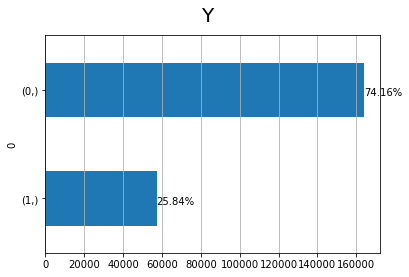

In [10]:
Y= pd.DataFrame(y_test)
ax = Y.value_counts().sort_values().plot(kind="barh")
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle("Y", fontsize=20)
plt.show()

## Simple Logistic Regressor (baseline model)

In [11]:
# evaluate a logistic regression model using k-fold cross-validation
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

In [14]:
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# create model
model = LogisticRegression()
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.765 (0.006)


In [15]:
model.fit(X_train, y_train)
## test
predicted_prob = model.predict_proba(X_test)[:,1]
predicted = model.predict(X_test)

## Accuray and AUC
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob)
print("Accuracy (overall correct predictions):",  round(accuracy,2))
print("Auc:", round(auc,2))
    
## Precision and Recall
recall = metrics.recall_score(y_test, predicted)
precision = metrics.precision_score(y_test, predicted)
print("Recall (all 1s predicted right):", round(recall,2))
print("Precision (confidence when predicting a 1):", round(precision,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted, target_names=[str(i) for i in np.unique(y_test)]))

C:\Users\wesli\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Accuracy (overall correct predictions): 0.78
Auc: 0.85
Recall (all 1s predicted right): 0.77
Precision (confidence when predicting a 1): 0.55
Detail:
              precision    recall  f1-score   support

           0       0.91      0.78      0.84    164108
           1       0.55      0.77      0.64     57192

    accuracy                           0.78    221300
   macro avg       0.73      0.78      0.74    221300
weighted avg       0.82      0.78      0.79    221300



### Random Forest

Accuracy (overall correct predictions): 0.83
Auc: 0.91
Recall (all 1s predicted right): 0.84
Precision (confidence when predicting a 1): 0.63
Detail:
              precision    recall  f1-score   support

           0       0.94      0.83      0.88    164108
           1       0.63      0.84      0.72     57192

    accuracy                           0.83    221300
   macro avg       0.79      0.84      0.80    221300
weighted avg       0.86      0.83      0.84    221300



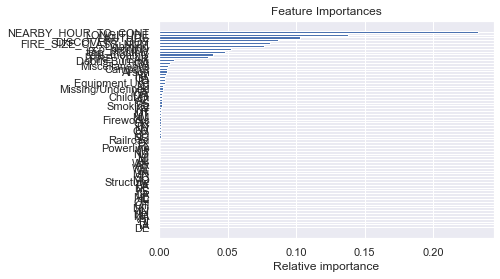

In [26]:
## call model
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
# fit model
rf.fit(X_train, y_train)

predicted_prob = rf.predict_proba(X_test)[:,1]
predicted = rf.predict(X_test)

## Accuray and AUC
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob)
print("Accuracy (overall correct predictions):",  round(accuracy,2))
print("Auc:", round(auc,2))
    
## Precision and Recall
recall = metrics.recall_score(y_test, predicted)
precision = metrics.precision_score(y_test, predicted)
print("Recall (all 1s predicted right):", round(recall,2))
print("Precision (confidence when predicting a 1):", round(precision,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted, target_names=[str(i) for i in np.unique(y_test)]))

importances = rf.feature_importances_
std = np.std([importances for tree in rf.estimators_], axis=0)
indic = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indic)), importances[indic], color='b', align='center', yerr=std[indic])
plt.yticks(range(len(indic)), [feature_names[i] for i in indic])
plt.xlabel('Relative importance')
plt.show()

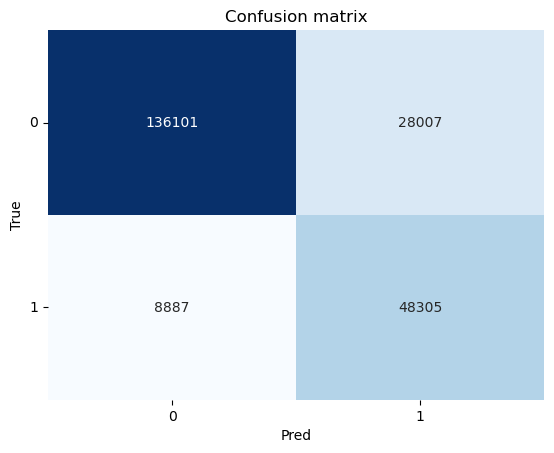

In [17]:
classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, predicted, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
plt.show()

### Gradient boosting

In [ ]:
# # for max_d in range(1,21):
#     model = ensemble.GradientBoostingClassifier(max_depth=max_d, random_state=42)
#     model.fit(X_train, y_train)
#     print('The Training Accuracy for max_depth {} is:'.format(max_d), model.score(X_train, y_train))
#     print('The Validation Accuracy for max_depth {} is:'.format(max_d), model.score(X_test,y_test))
#     print('')

    
# Took more than 2 hours to run only 20 parameters testing... Choose max depth = 10 as it is give the best results without overfitting

C:\Users\wesli\AppData\Local\Temp\ipykernel_9096\3878110462.py:14: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

C:\Users\wesli\AppData\Local\Temp\ipykernel_9096\3878110462.py:14: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

C:\Users\wesli\AppData\Local\Temp\ipykernel_9096\3878110462.py:14: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

C:\Users\wesli\AppData\Local\Temp\ipykernel_9096\3878110462.py:14: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

C:\Users\wesli\AppData\Local\Temp\ipykernel_9096\3878110462.py:14: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



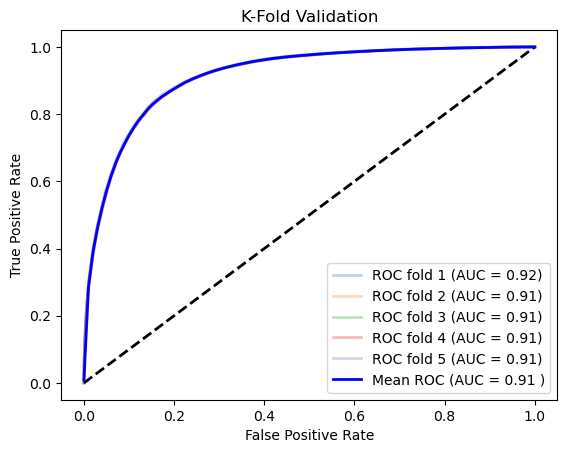

In [18]:
## call model
GB = ensemble.GradientBoostingClassifier(max_depth=10, random_state=42)

# Cross validation
cv = model_selection.StratifiedKFold(n_splits=5, shuffle=True)
tprs, aucs = [], []
mean_fpr = np.linspace(0,1,100)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
    prediction = GB.fit(X_train[train],
                y_train[train]).predict_proba(X_train[test])
    fpr, tpr, t = metrics.roc_curve(y_train[test], prediction[:, 1])
    tprs.append(scipy.interp(mean_fpr, fpr, tpr))
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i = i+1
   
plt.plot([0,1], [0,1], linestyle='--', lw=2, color='black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Fold Validation')
plt.legend(loc="lower right")
plt.show()

In [27]:
GB.fit(X_train, y_train)
## test
predicted = GB.predict(X_test)
predicted_prob = GB.predict_proba(X_test)[:,1]

In [28]:
## Accuray e AUC
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob)
print("Accuracy (overall correct predictions):",  round(accuracy,2))
print("Auc:", round(auc,2))
    
## Precision e Recall
recall = metrics.recall_score(y_test, predicted)
precision = metrics.precision_score(y_test, predicted)
print("Recall (all 1s predicted right):", round(recall,2))
print("Precision (confidence when predicting a 1):", round(precision,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted, target_names=[str(i) for i in np.unique(y_test)]))

Accuracy (overall correct predictions): 0.83
Auc: 0.91
Recall (all 1s predicted right): 0.86
Precision (confidence when predicting a 1): 0.63
Detail:
              precision    recall  f1-score   support

           0       0.94      0.82      0.88    164108
           1       0.63      0.86      0.73     57192

    accuracy                           0.83    221300
   macro avg       0.79      0.84      0.80    221300
weighted avg       0.86      0.83      0.84    221300



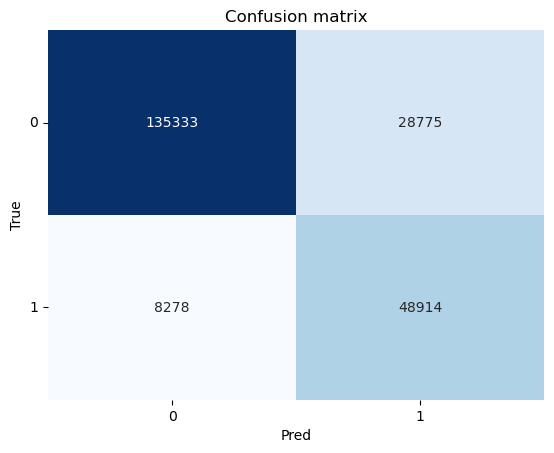

In [21]:
classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, predicted, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
plt.show()

### Neural network

In [12]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [13]:
model = Sequential() 
model.add(Dense(128, activation='relu', input_dim=70))
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               9088      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3870      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 12,989
Trainable params: 12,989
Non-trainable params: 0
_________________________________________________________________


In [18]:
hist = model.fit(X_train, Y_train, validation_data=(X_test, y_test), epochs=10, batch_size=25)

Train on 339514 samples, validate on 221300 samples
Epoch 1/10
339514/339514 [==============================] - 50s 147us/step - loss: 0.4639 - accuracy: 0.7932 - val_loss: 0.4592 - val_accuracy: 0.7753
Epoch 2/10
339514/339514 [==============================] - 48s 142us/step - loss: 0.4320 - accuracy: 0.8060 - val_loss: 0.3972 - val_accuracy: 0.8156
Epoch 3/10
339514/339514 [==============================] - 51s 151us/step - loss: 0.4239 - accuracy: 0.8103 - val_loss: 0.4132 - val_accuracy: 0.8052
Epoch 4/10
339514/339514 [==============================] - 59s 173us/step - loss: 0.4218 - accuracy: 0.8120 - val_loss: 0.3863 - val_accuracy: 0.8233
Epoch 5/10
339514/339514 [==============================] - 144s 423us/step - loss: 0.4194 - accuracy: 0.8135 - val_loss: 0.4256 - val_accuracy: 0.7963
Epoch 6/10
339514/339514 [==============================] - 226s 665us/step - loss: 0.4184 - accuracy: 0.8138 - val_loss: 0.4367 - val_accuracy: 0.7949
Epoch 7/10
339514/339514 [==============

[]

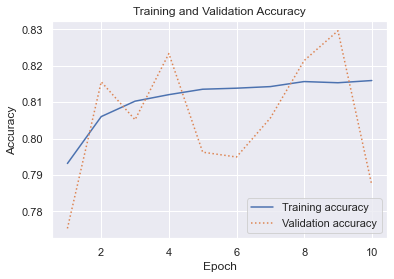

In [19]:
%matplotlib inline
sns.set()
 
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [24]:
y_predicted = model.predict(X_test) > 0.5

## test
predicted_prob = model.predict_proba(X_test)
predicted = model.predict(X_test)

## Accuracy
accuracy = metrics.accuracy_score(y_test, y_predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob)
print("Accuracy (overall correct predictions):",  round(accuracy,2))
print("Auc:", round(auc,2))

## Accuray e AUC
accuracy = metrics.accuracy_score(y_test, y_predicted)
print("Accuracy (overall correct predictions):",  round(accuracy,2))
    
## Precision e Recall
recall = metrics.recall_score(y_test, y_predicted)
precision = metrics.precision_score(y_test, y_predicted)
print("Recall (all 1s predicted right):", round(recall,2))
print("Precision (confidence when predicting a 1):", round(precision,2))
print("Detail:")
print(metrics.classification_report(y_test, y_predicted, target_names=[str(i) for i in np.unique(y_test)]))

Accuracy (overall correct predictions): 0.79
Auc: 0.9
Accuracy (overall correct predictions): 0.79
Recall (all 1s predicted right): 0.87
Precision (confidence when predicting a 1): 0.56
Detail:
              precision    recall  f1-score   support

           0       0.95      0.76      0.84    164108
           1       0.56      0.87      0.68     57192

    accuracy                           0.79    221300
   macro avg       0.75      0.82      0.76    221300
weighted avg       0.84      0.79      0.80    221300



Text(89.18, 0.5, 'Actual label')

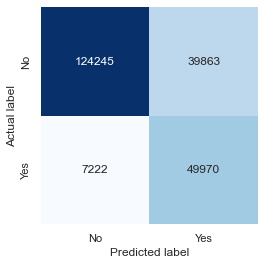

In [25]:
from sklearn.metrics import confusion_matrix


mat = confusion_matrix(y_test, y_predicted)
labels = ['No', 'Yes']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

### Decision Tree


In [35]:
# from sklearn.tree import DecisionTreeClassifier
# for max_d in range(1,21):
#     model = DecisionTreeClassifier(max_depth=max_d, random_state=42)
#     model.fit(X_train, y_train)
#     print('The Training Accuracy for max_depth {} is:'.format(max_d), model.score(X_train, y_train))
#     print('The Validation Accuracy for max_depth {} is:'.format(max_d), model.score(X_test,y_test))
#     print('')

The Training Accuracy for max_depth 1 is: 0.7273663382329187
The Validation Accuracy for max_depth 1 is: 0.7964098976690792

The Training Accuracy for max_depth 2 is: 0.763570967072017
The Validation Accuracy for max_depth 2 is: 0.7857866745589726

The Training Accuracy for max_depth 3 is: 0.7681657705886425
The Validation Accuracy for max_depth 3 is: 0.7864548300015246

The Training Accuracy for max_depth 4 is: 0.7781601172208505
The Validation Accuracy for max_depth 4 is: 0.7865265782369665

The Training Accuracy for max_depth 5 is: 0.7879035235480075
The Validation Accuracy for max_depth 5 is: 0.8031318104770361

The Training Accuracy for max_depth 6 is: 0.7977017329302906
The Validation Accuracy for max_depth 6 is: 0.8203289656595009

The Training Accuracy for max_depth 7 is: 0.8034618224611764
The Validation Accuracy for max_depth 7 is: 0.8127819481439629

The Training Accuracy for max_depth 8 is: 0.8126485451231049
The Validation Accuracy for max_depth 8 is: 0.8179209155074842

T

We choose max_depth = 10

Accuracy (overall correct predictions): 0.82
Auc: 0.9
Recall (all 1s predicted right): 0.81
Precision (confidence when predicting a 1): 0.62
Detail:
              precision    recall  f1-score   support

           0       0.93      0.83      0.87    164718
           1       0.62      0.81      0.71     58284

    accuracy                           0.82    223002
   macro avg       0.78      0.82      0.79    223002
weighted avg       0.85      0.82      0.83    223002



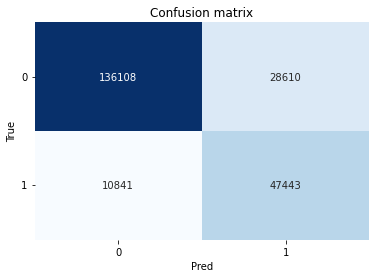

In [36]:
model = DecisionTreeClassifier(max_depth=10, random_state=42)

model.fit(X_train, y_train)
## test
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)[:,1]

## Accuray e AUC
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob)
print("Accuracy (overall correct predictions):",  round(accuracy,2))
print("Auc:", round(auc,2))
    
## Precision e Recall
recall = metrics.recall_score(y_test, predicted)
precision = metrics.precision_score(y_test, predicted)
print("Recall (all 1s predicted right):", round(recall,2))
print("Precision (confidence when predicting a 1):", round(precision,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted, target_names=[str(i) for i in np.unique(y_test)]))

classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, predicted, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
plt.show()


### Explainable AI

In [25]:
pip install shap

     ------------------------------------- 435.6/435.6 kB 26.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [26]:
# Imports
import shap

In [27]:
# Fits the explainer
explainer = shap.Explainer(GB.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

Permutation explainer: 221301it [2:38:23, 23.26it/s]                              


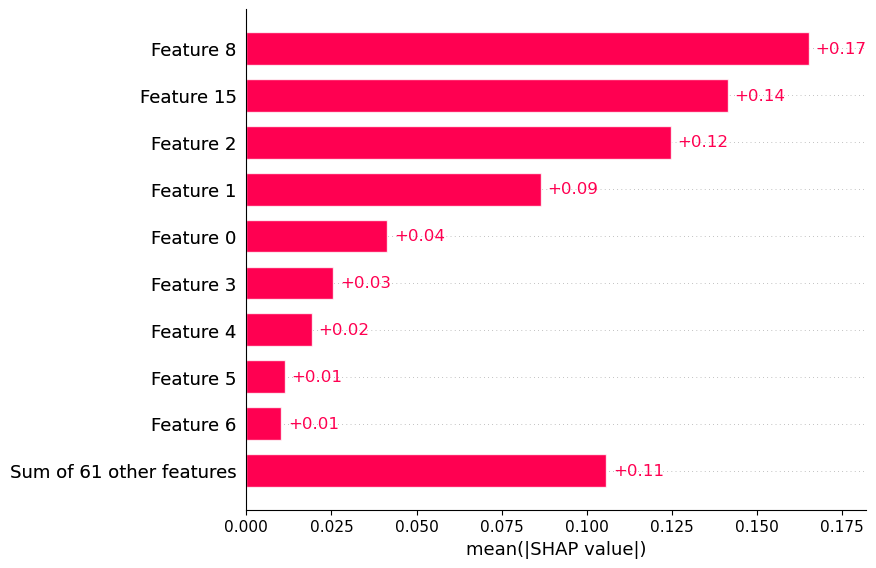

In [28]:
shap.plots.bar(shap_values)


In [17]:
mX.columns

Index(['LATITUDE', 'LONGITUDE', 'FIRE_SIZE_CLASS_NUM', 'DISCOVERY_DOY',
       'FIRE_YEAR', 'tmp_monthly', 'pcp_monthly', 'pdsi_monthly',
       'NEARBY_HOUR_TO_CONT', 'Arson', 'Campfire', 'Children',
       'Debris Burning', 'Equipment Use', 'Fireworks', 'Lightning',
       'Miscellaneous', 'Missing/Undefined', 'Powerline', 'Railroad',
       'Smoking', 'Structure', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL',
       'GA', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI',
       'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY',
       'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT',
       'WA', 'WI', 'WV', 'WY'],
      dtype='object')

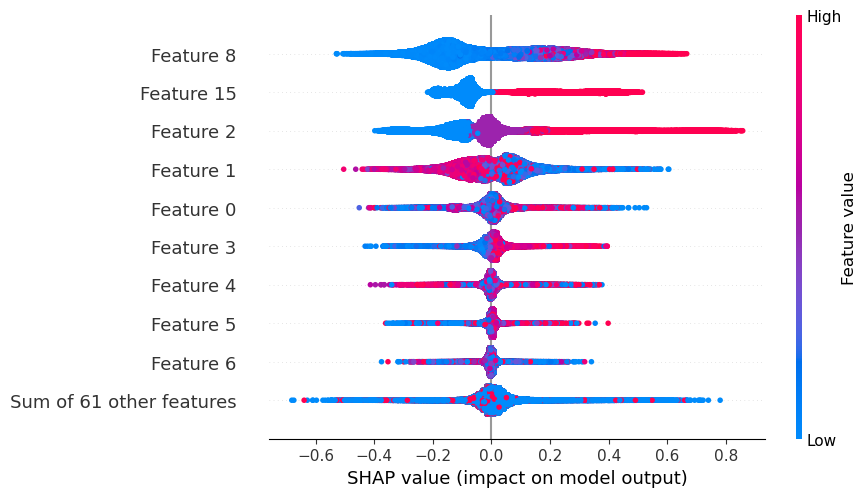

In [31]:
shap.plots.beeswarm(shap_values)